In [25]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Part 1

#### 1. Get the data

In [26]:
diabetes = load_diabetes(as_frame=True)
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names) 
y = pd.Series(diabetes.target, name="target")                    
df = pd.concat([X, y], axis=1)

print(df.head().to_string()) 
print(df.describe().to_string())
print(df.shape)

df.head()


        age       sex       bmi        bp        s1        s2        s3        s4        s5        s6  target
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401 -0.002592  0.019907 -0.017646   151.0
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412 -0.039493 -0.068332 -0.092204    75.0
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356 -0.002592  0.002861 -0.025930   141.0
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038  0.034309  0.022688 -0.009362   206.0
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142 -0.002592 -0.031988 -0.046641   135.0
                age           sex           bmi            bp            s1            s2            s3            s4            s5            s6      target
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  442.000000
mean  -2.511817e-19  1.2

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


#### 2. Frame the Problem. 
  Notice that the dependent variable of diabetes progression is "disease progression one year after baseline".

- Objective: Predict disease progression one year after baseline from individual characteristics (age, BMI, blood pressure, lipid and glucose indicators).

- Problem Type: Regression. (Continuous numerical data)

- Inputs: age, sex, bmi, bp, s1–s6 (standardized features).
  - bmi: body mass index  
  - bp: average blood pressure  
  - s1: tc, total serum cholesterol  
  - s2: ldl, low-density lipoproteins  
  - s3: hdl, high-density lipoproteins  
  - s4: tch, total cholesterol / HDL  
  - s5: ltg, possibly log of serum triglycerides level  
  - s6: glu, blood sugar level  
- Target: target (continuous score) - disease progression score  

- Evaluation Metrics: R², MAE, and MAPE

- Potential Use: Early screening, risk stratification, and support for care planning.

- Interpretation Note: Because the predictors are standardized while the target is not, each coefficient represents the expected change in the target (in its original units) associated with a one–standard-deviation increase in the corresponding feature

#### 3. EDA
Describe the data, explore it, and provide insights about it.

- Statistics

In [27]:
print(df.info())               # Check summary of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
None


In [28]:
print(df.isna().sum())            # Missing values


age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


In [29]:
print("Constant/ID-like features: \n", df.nunique())         # Check for constant/ID-like features
print("---------------")                                     
print("Describe: \n",df.describe().to_string())              # Descriptive statistics (numeric summary)

Constant/ID-like features: 
 age        58
sex         2
bmi       163
bp        100
s1        141
s2        302
s3         63
s4         66
s5        184
s6         56
target    214
dtype: int64
---------------
Describe: 
                 age           sex           bmi            bp            s1            s2            s3            s4            s5            s6      target
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  442.000000
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17  3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17  152.133484
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   77.093005
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01 -1.156131e-01 -1.023071e-01 -7.639450e-02 -1.260971e-01 -1.377672e-0

We can check Size of the data.  
No missing value, data type - float64, No constant/ID-like features

> No need to clean the data

10 features (X) is standardized value -> mean value is near 0

- Histogram

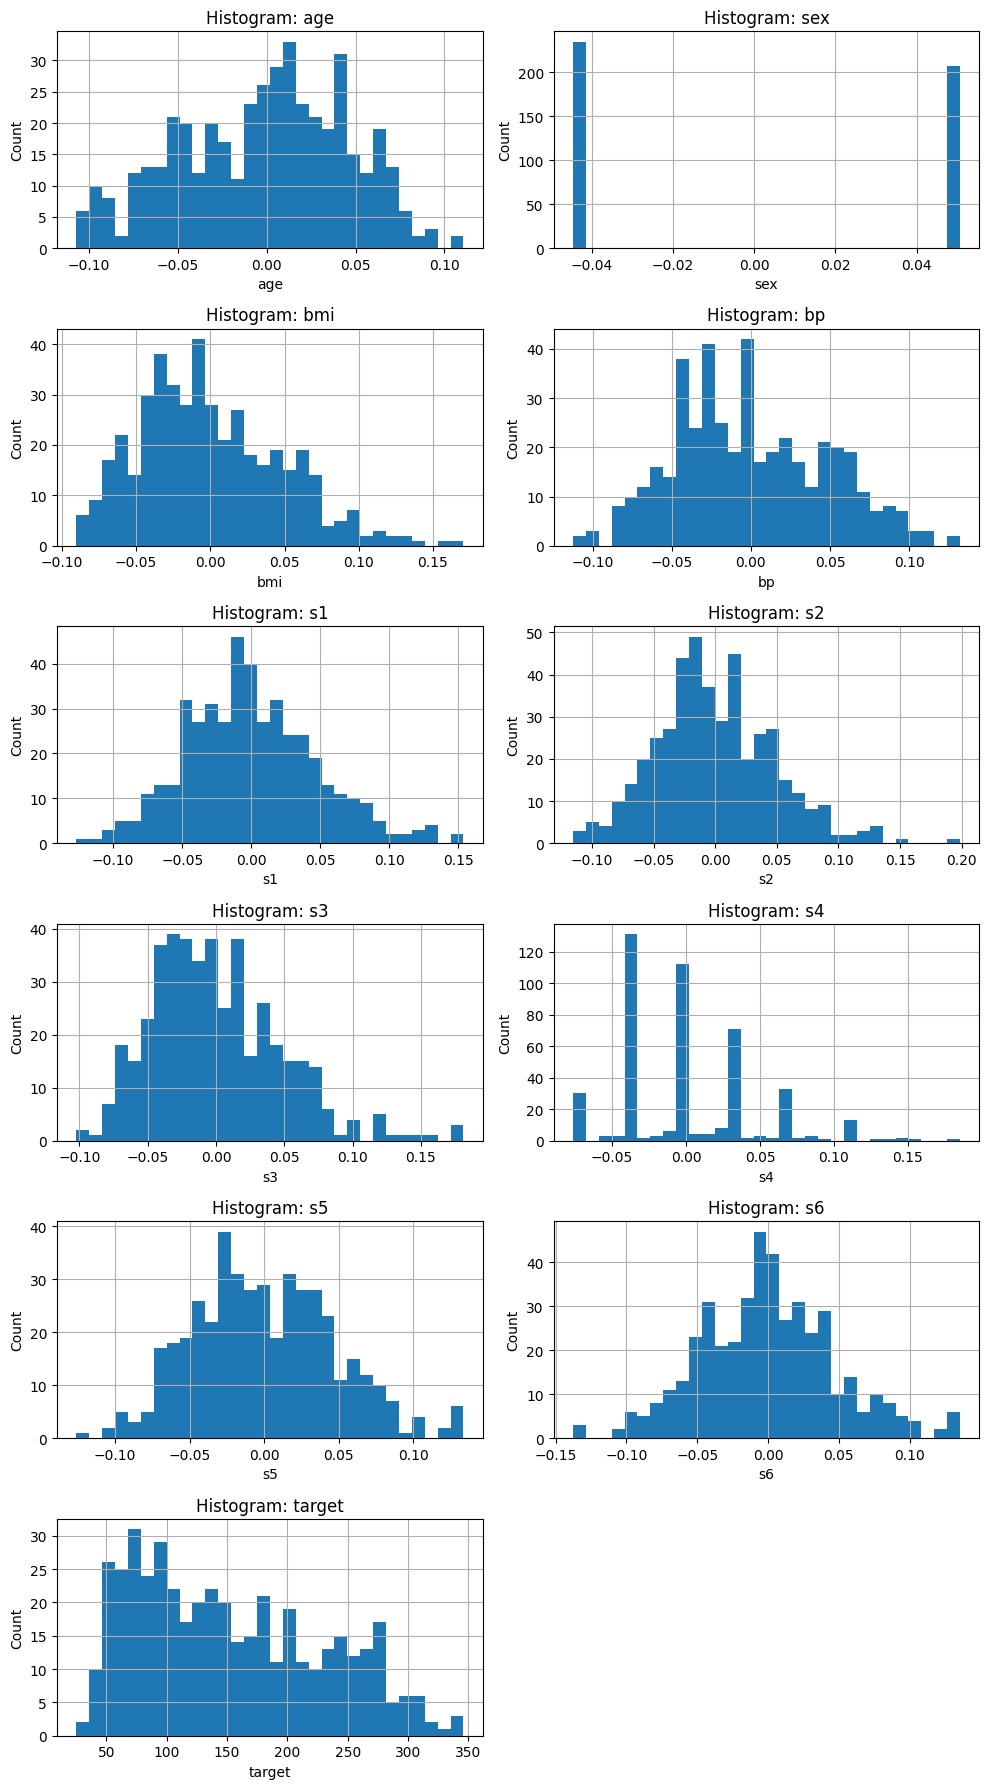

In [30]:

import math
import matplotlib.pyplot as plt

cols = list(df.columns)
n = len(cols)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3*nrows))
axes = axes.ravel()

for i, c in enumerate(cols):
    df[c].hist(ax=axes[i], bins=30)
    axes[i].set_title(f"Histogram: {c}")
    axes[i].set_xlabel(c)
    axes[i].set_ylabel("Count")

# Hide the remaining axis
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Check the distribution shape (skewness/tails).   
X is almost symmetric, target have skewness.  

- Scatter

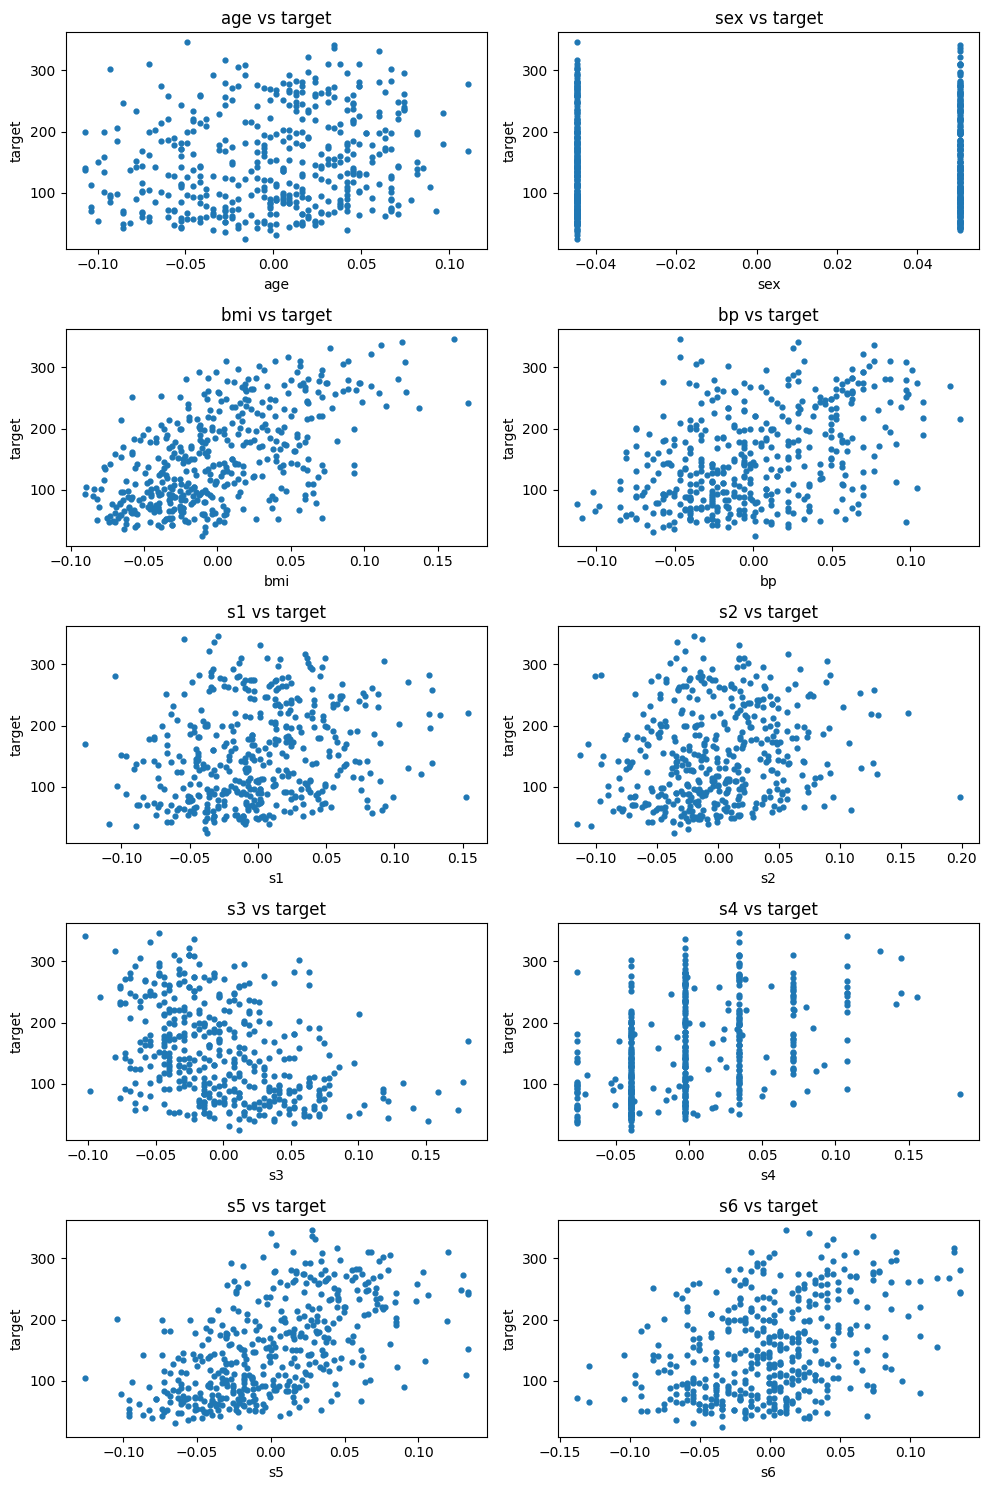

In [31]:
cols = list(X.columns)
n = len(cols)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3*nrows))
axes = axes.ravel()

for i, c in enumerate(cols):
    axes[i].scatter(df[c], df["target"], s=12)
    axes[i].set_title(f"{c} vs target")
    axes[i].set_xlabel(c)
    axes[i].set_ylabel("target")

# Hide the remaining axis
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Correlation direction in the direction of the slope:  
> bmi, bp, s5 seems a tendency to be positive  
> s3 tend to be negative

Other data can be assumed to have a weak correlation.

- Correlation matrix

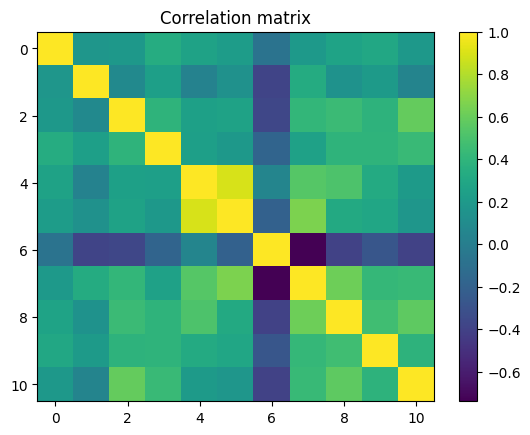

Top + corr:
 bmi    0.586450
s5     0.565883
bp     0.441482
Name: target, dtype: float64 
Top - corr:
 s2     0.174054
sex    0.043062
s3    -0.394789
Name: target, dtype: float64


In [32]:
corr = df.corr(numeric_only=True)
plt.imshow(corr, aspect='auto'); plt.colorbar(); plt.title("Correlation matrix"); plt.show()

target_corr = corr["target"].drop("target").sort_values(ascending=False)
top_pos = target_corr.head(3); top_neg = target_corr.tail(3)
print("Top + corr:\n", top_pos, "\nTop - corr:\n", top_neg)

- If the cell between column 10 (target) and any column 0–9 is bright green, the correlation is positive; if it’s dark blue, the correlation is negative—so we can review the results at a glance.

- This matrix also lets you check correlations among the features themselves. (Example: s4 shows a high correlation with s1 and s3)

#### 4. Clean the data
- No missing data
- Check Outlier, but not delete it

In [33]:
z = X.apply(zscore)
outliers = (np.abs(z) > 3).any(axis=1).sum()
print(f"|z|>3 row: {outliers}/{len(X)}")

|z|>3 row: 12/442


#### 5. Split

In [34]:
# 1) split 25% of Total data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, random_state=42                                      # random_state=42 is for reproducibility
)
# 2) divide 25$ to val(10%) / test(15%) by using 40:60 ratio
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.6, random_state=42
)

# Print for verification
n = len(df)
print(
    f"Train {len(X_train)}({len(X_train)/n:.1%}), "
    f"Val {len(X_val)}({len(X_val)/n:.1%}), "
    f"Test {len(X_test)}({len(X_test)/n:.1%})"
)

Train 331(74.9%), Val 44(10.0%), Test 67(15.2%)


# Part 2

#### 6. Models: a univariate polynomial regression on the BMI feature versus  
   the "disease progression one year after baseline" - from degree 0 to 5 (6 models)

In [35]:
# MAPE: Mean Absolute Percentage Error (eps to avoid division by 0)
def mape(y_true, y_pred, eps=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

# Extract BMI as a single feature (keep 2D shape)
Xtr_bmi = X_train[['bmi']].values
Xval_bmi = X_val[['bmi']].values
Xte_bmi = X_test[['bmi']].values

results = []
models = {}

for deg in range(0, 6):  # degree 0~5
     # include_bias=True + fit_intercept=False => treat the intercept via the polynomial '1' feature
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=deg, include_bias=True)),
        ("lin",  LinearRegression(fit_intercept=False))                # Set the constant term (1) just created to act as an intercept.
    ])
    model.fit(Xtr_bmi, y_train)
    models[deg] = model

    # Performance (train/val)
    pred_tr  = model.predict(Xtr_bmi)
    pred_val = model.predict(Xval_bmi)

    r2_tr  = r2_score(y_train, pred_tr)
    r2_val = r2_score(y_val,   pred_val)
    mae_tr  = mean_absolute_error(y_train, pred_tr)
    mae_val = mean_absolute_error(y_val,   pred_val)
    mape_tr = mape(y_train, pred_tr)
    mape_val= mape(y_val,   pred_val)

    results.append({
        "degree": deg,
        "R2_train": r2_tr, "R2_val": r2_val,
        "MAE_train": mae_tr, "MAE_val": mae_val,
        "MAPE_train": mape_tr, "MAPE_val": mape_val
    })

results_df = pd.DataFrame(results).sort_values("R2_val", ascending=False)
results_df

,degree,R2_train,R2_val,MAE_train,MAE_val,MAPE_train,MAPE_val
5,5,3.541003e-01,0.349881,52.059191,45.462121,48.004022,45.175275
4,4,3.530137e-01,0.340758,52.092653,46.090118,48.053266,46.050330
3,3,3.507740e-01,0.331638,52.198968,47.185414,48.280744,47.222673
2,2,3.507639e-01,0.331631,52.207314,47.213700,48.298534,47.239667
1,1,3.496719e-01,0.331264,52.287739,47.208472,48.362886,47.060009
0,0,-2.220446e-16,-0.106957,66.201641,66.057059,62.826669,71.263880


#### 7. Compare the models using the training and validation data.
Construct a table to summarize the training validation results. Each model should have a separate row in the table:  
    1. R-Squared  
    2. Mean Absolute Error (MAE)  
    3. MAPE  

In [36]:
display(results_df.round(2))

,degree,R2_train,R2_val,MAE_train,MAE_val,MAPE_train,MAPE_val
5,5,0.35,0.35,52.06,45.46,48.00,45.18
4,4,0.35,0.34,52.09,46.09,48.05,46.05
3,3,0.35,0.33,52.20,47.19,48.28,47.22
2,2,0.35,0.33,52.21,47.21,48.30,47.24
1,1,0.35,0.33,52.29,47.21,48.36,47.06
0,0,-0.00,-0.11,66.20,66.06,62.83,71.26


#### 8. Identify the best model based on the table above.

The model is good for predict : R2 is bigger (closer to 1), MAE & MAPE is smaller (sloser to 0)  
for checking **Step 7**, Degree with '5' seems highest R2_val, Lowest MAE_val & MAPE_val.  
So we can know degree with 5 is the best model.

In [37]:
# Best by R2_val
best_row = results_df.sort_values(["R2_val","MAE_val","MAPE_val"], ascending=[False, True, True]).iloc[0]      
# Chose the biggest 'R2_val', If it is same chose the smaller 'MAE_val', If it is same chose smaller 'MAPE_val'
best_deg = int(best_row["degree"])
best_model = models[best_deg]
best_deg, best_row.to_dict()

(5,
 {'degree': 5.0,
  'R2_train': 0.35410026418135754,
  'R2_val': 0.34988122550535294,
  'MAE_train': 52.059190859438374,
  'MAE_val': 45.462121227679326,
  'MAPE_train': 48.00402175266857,
  'MAPE_val': 45.175275176457724})

#### 9. Run the chosen model on the test set and provide results (R-Squared, MAPE, MAE)

In [38]:
pred_test = best_model.predict(Xte_bmi)

r2_te  = r2_score(y_test, pred_test)
mae_te = mean_absolute_error(y_test, pred_test)
mape_te= mape(y_test, pred_test)

print(f"[Test] degree={best_deg} | R2={r2_te:.4f}  MAE={mae_te:.4f}  MAPE={mape_te:.2f}%")

[Test] degree=5 | R2=0.2667  MAE=51.7503  MAPE=43.03%


#### 10. Plot a graph (train, validation, and test data points) and the fit of the chosen model over each of them

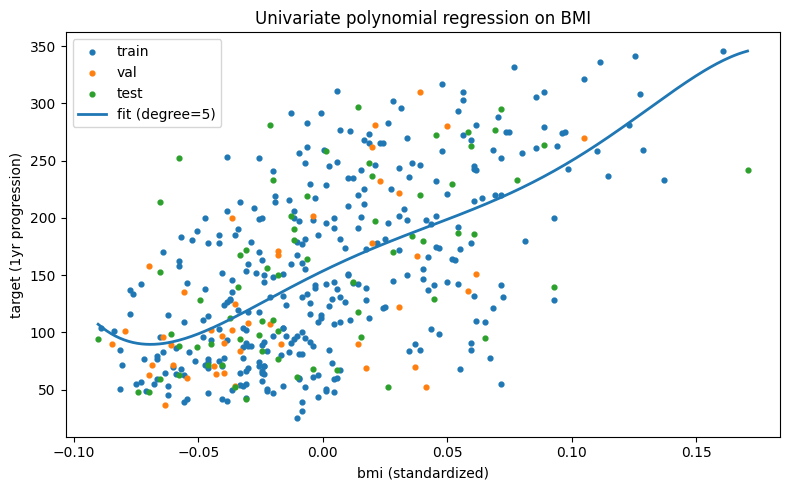

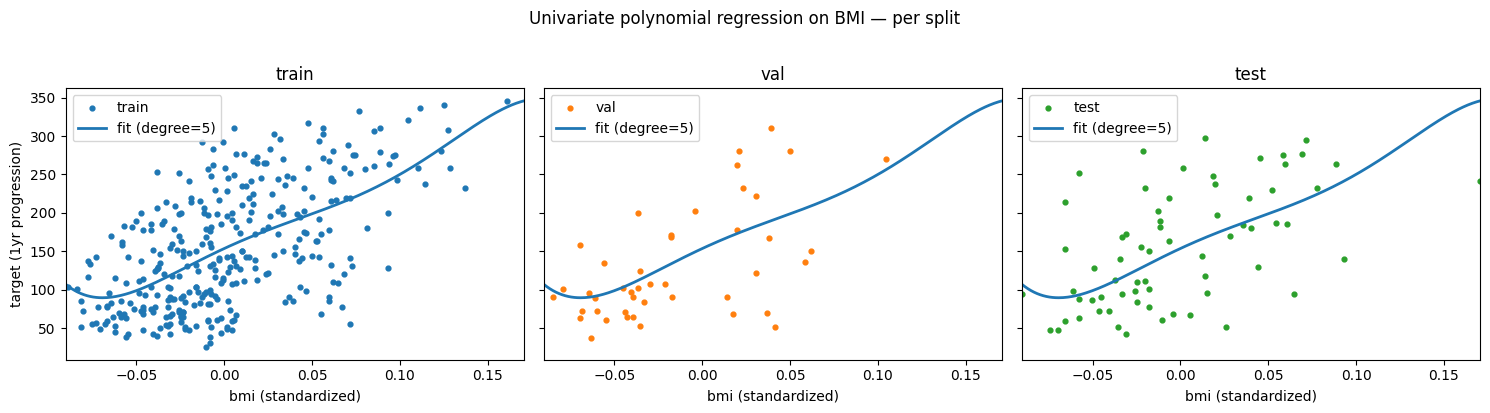

In [39]:
# Create a BMI range to draw a smooth curve across the full range
bmi_all = np.vstack([Xtr_bmi, Xval_bmi, Xte_bmi]).ravel()
bmi_min, bmi_max = bmi_all.min(), bmi_all.max()
bmi_grid = np.linspace(bmi_min, bmi_max, 300).reshape(-1, 1)
y_fit = best_model.predict(bmi_grid)

y_all = np.concatenate([y_train, y_val, y_test])
y_pad = (y_all.max() - y_all.min()) * 0.05
ylims = (y_all.min() - y_pad, y_all.max() + y_pad)

# train/val/test in one plot
plt.figure(figsize=(8,5))
plt.scatter(Xtr_bmi, y_train, s=12, label="train")
plt.scatter(Xval_bmi, y_val,   s=12, label="val")
plt.scatter(Xte_bmi, y_test,   s=12, label="test")
plt.plot(bmi_grid, y_fit, linewidth=2, label=f"fit (degree={best_deg})")
plt.xlabel("bmi (standardized)"); plt.ylabel("target (1yr progression)")
plt.title("Univariate polynomial regression on BMI")
plt.legend()
plt.tight_layout()
plt.show()

# train/val/test each plot
palette = {"train": "tab:blue", "val": "tab:orange", "test": "tab:green"}
panels = [("train", Xtr_bmi, y_train),
          ("val",   Xval_bmi, y_val),
          ("test",  Xte_bmi, y_test)]

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)
for ax, (name, Xbmi, y) in zip(axes, panels):
    ax.scatter(Xbmi, y, s=12, color=palette[name], label=name)
    ax.plot(bmi_grid, y_fit, linewidth=2, label=f"fit (degree={best_deg})") 
    ax.set_xlim(bmi_min, bmi_max); ax.set_xlabel("bmi (standardized)")
    ax.set_title(name); ax.legend()

axes[0].set_ylabel("target (1yr progression)")
fig.suptitle("Univariate polynomial regression on BMI — per split", y=1.02)
plt.tight_layout()
plt.show()



#### 11. Write down the equation of the best model (with a two-decimal-digit precision, assuming it's sufficient)

In [40]:
poly = best_model.named_steps["poly"]
lin  = best_model.named_steps["lin"]

names = poly.get_feature_names_out(["bmi"])  # ['1','bmi','bmi^2',...]
coefs = lin.coef_                            # Since fit_intercept=False, the intercept (constant term) is included in coef

terms = []
for name, w in zip(names, coefs):
    terms.append(f"{w:.2f}*{name}")

equation = " + ".join(terms).replace("*1", "")  # The first term is the constant (bias)
print(f"Best model (degree={best_deg}) equation:\n  y = {equation}")

Best model (degree=5) equation:
  y = 153.65 + 1059.89*bmi + -3824.15*bmi^2 + -16770.23*bmi^3 + 753722.52*bmi^4 + -2993716.57*bmi^5


#### 12. Calculate the expected diabetes progression for a BMI value of your choice using `model.predict()` for that value

In [41]:
bmi_value = [0, -0.05, 0.05, 0.10]  # Standardized BMI values ​​(select within the data range)

for z in bmi_value:
    y_hat = best_model.predict([[z]])[0]
    print(f"Predicted target at bmi={z:.2f}: {y_hat:.2f}")

Predicted target at bmi=0.00: 153.65
Predicted target at bmi=-0.05: 98.84
Predicted target at bmi=0.05: 198.77
Predicted target at bmi=0.10: 250.07


#### 13. How many trainable parameters are we fitting for each of the models? Explain these values. One way is to use the sklearn function `get_feature_names_out()`

For univariate polynomial regression on standardized BMI, the number of trainable parameters equals the number of polynomial terms (including the constant).  
We can see the result that **n_params = degree+1**, and we can check each features name by using get_feature_names_out()

In [42]:
param_counts = []
for d in range(0, 6):
    mdl = models[d]
    names = mdl.named_steps["poly"].get_feature_names_out(["bmi"])
    param_counts.append({"degree": d, "n_params": len(names), "features": list(names)})

pd.DataFrame(param_counts)

,degree,n_params,features
0,0,1,[1]
1,1,2,"[1, bmi]"
2,2,3,"[1, bmi, bmi^2]"
3,3,4,"[1, bmi, bmi^2, bmi^3]"
4,4,5,"[1, bmi, bmi^2, bmi^3, bmi^4]"
5,5,6,"[1, bmi, bmi^2, bmi^3, bmi^4, bmi^5]"


#### 14. Provide a conclusion section. In particular, conduct a thorough analysis of where the model fails, and include a brief section in the conclusions that describes the model's limitations. This should be in addition to summarizing its performance.

> Summary of performance.
 - The univariate polynomial model on standardized BMI (degree = 5) achieved  
 - **Validation - R²≈0.35, MAE≈45.46, MAPE≈45.18%**  
 - **Test - R²≈0.27, MAE≈51.75, MAPE≈43.03%**

> Model Analysis
 - R² around 0.27–0.35 says BMI alone explains only part of the target variation.   
 - When comparing the Train/Validation/Test results, there are some differences in the values, but the overall trend is similar.  
 - The plot clearly shows a nonlinear upward trend: higher BMI → higher predicted progression.

> Where the model fails
 - In the high-BMI range, errors grow larger, which negatively impacts predictions.  
 - Biological data is driven by many interacting factors, so BMI alone is insufficient to explain the outcomes.  
 - Leaving out other variables introduces omitted-variable bias, which reduces the model’s explanatory power.  
 - Datasets with diverse patterns (like biomedical data) are hard to capture with a single curve/polynomial model.  
 - As seen in the Step 10 plots, the Train/Validation/Test splits do not appear to have evenly balanced distributions → we may need more data or to adjust the split percentages.

> limitation

 - Only one feature is used → limited explanatory power and accuracy.
 - Very vulnerable to data outside the training set (poor generalization) — similar issues are visible in the Step 10 plots.
 - Sensitive to outliers/noise (because the loss is based on squared errors).
 - We did not observe major problems up to a 6th-degree polynomial, but pushing to higher degrees to “improve” the model would increase overfitting risk.

> Improvements

 - Build a multivariate model including features with confirmed correlations (e.g., bmi, s5, bp) which we seen at /to increase explanatory power.
 - Use K-Fold cross-validation to make validation performance more stable.  
 - Compare alternative models, such as decision trees and k-NN.


# Part 3

0) Common setup (optional feature drop, evaluation utils)

In [43]:
# --- (Optional) drop weak/undesired features based on EDA ---
# Drop only "sex"
drop_cols = ["sex"]          # default: keep all

def use_cols(X):
    return X.drop(columns=drop_cols) if drop_cols else X

# --- Regression: MAPE (avoid division by zero) ---
def mape(y_true, y_pred, eps=1e-8):
    return float(np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100)

# --- Regression evaluation on train/val ---
def eval_reg(model, Xtr, ytr, Xv, yv):
    pred_tr = model.predict(Xtr)
    pred_v  = model.predict(Xv)
    return {
        "R2_train":  r2_score(ytr, pred_tr),
        "R2_val":    r2_score(yv,  pred_v),
        "MAE_train": mean_absolute_error(ytr, pred_tr),
        "MAE_val":   mean_absolute_error(yv,  pred_v),
        "MAPE_train": mape(ytr, pred_tr),
        "MAPE_val":   mape(yv,  pred_v),
    }

# --- Classification evaluation (binary) on train/val ---
def eval_clf(model, Xtr, ytr_bin, Xv, yv_bin, pos_label=1):
    # probabilities for ROC-AUC; fall back to decision_function if unavailable
    if hasattr(model, "predict_proba"):
        proba_tr = model.predict_proba(Xtr)[:, 1]
        proba_v  = model.predict_proba(Xv)[:, 1]
    else:
        proba_tr = model.decision_function(Xtr)
        proba_v  = model.decision_function(Xv)

    pred_tr = (proba_tr >= 0.5).astype(int)
    pred_v  = (proba_v  >= 0.5).astype(int)

    acc_tr = accuracy_score(ytr_bin, pred_tr)
    acc_v  = accuracy_score(yv_bin,  pred_v)
    p_tr, r_tr, f1_tr, _ = precision_recall_fscore_support(
        ytr_bin, pred_tr, average="binary", pos_label=pos_label, zero_division=0
    )
    p_v,  r_v,  f1_v,  _ = precision_recall_fscore_support(
        yv_bin, pred_v,  average="binary", pos_label=pos_label, zero_division=0
    )
    # Use ROC-AUC as a threshold-independent metric
    auc_tr = roc_auc_score(ytr_bin, proba_tr)
    auc_v  = roc_auc_score(yv_bin,  proba_v)

    return {
        "ACC_train": acc_tr, "ACC_val": acc_v,
        "Precision_train": p_tr, "Precision_val": p_v,
        "Recall_train": r_tr, "Recall_val": r_v,
        "F1_train": f1_tr, "F1_val": f1_v,
        "ROC_AUC_train": auc_tr, "ROC_AUC_val": auc_v
    }

# --- Apply optional drop to splits ---
Xtr = use_cols(X_train)
Xv  = use_cols(X_val)
Xte = use_cols(X_test)

1) Multivariate polynomial regression (two degrees > 1)
 - If the deg is >= 4, R2_train = 1, MAE&MAPE_train = 0, but the result with validation is not similar. This means **Overfitting** 
 - also with degree 3 , it seems overfitting trends

In [52]:
reg_results = []
reg_models = {}

for deg in [2, 3]:  # degrees > 1
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=deg, include_bias=True)),
        ("lin",  LinearRegression(fit_intercept=False))
    ])
    model.fit(Xtr, y_train)
    scores = eval_reg(model, Xtr, y_train, Xv, y_val)
    reg_models[f"poly_deg{deg}"] = model
    reg_results.append({"model": f"poly_deg{deg}", **scores})

reg_table = pd.DataFrame(reg_results).sort_values("R2_val", ascending=False)
display(reg_table.round(4))

,model,R2_train,R2_val,MAE_train,MAE_val,MAPE_train,MAPE_val
0,poly_deg2,0.5748,0.3992,41.4222,41.9227,36.5276,41.0007
1,poly_deg3,0.8000,-19.6076,25.2915,145.6543,23.8670,134.0140


2) Decision tree regressors (two variants, e.g., different max_depth)

 - As the number of branches increases, overfitting increases ↑ 
 - Select an appropriate depth based on verification performance.
 - If I select the depth over 5 - it seems trend of overfitting -> I select 3 & 4

In [45]:
tree_results = []
tree_models = {}
for depth in [3, 4]:  # shallow vs full depth
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(Xtr, y_train)
    scores = eval_reg(model, Xtr, y_train, Xv, y_val)
    name = f"tree_depth{depth if depth is not None else 'None'}"
    tree_models[name] = model
    tree_results.append({"model": name, **scores})

tree_table = pd.DataFrame(tree_results).sort_values("R2_val", ascending=False)
display(tree_table.round(4))

,model,R2_train,R2_val,MAE_train,MAE_val,MAPE_train,MAPE_val
0,tree_depth3,0.5095,0.1983,44.2599,48.1262,38.8666,47.6729
1,tree_depth4,0.5827,0.1356,39.8157,49.9600,35.3041,48.8994


3) kNN regressors
 - with k > 15 , R2_val value decrase, So i select 15 to large K 

In [46]:
knn_results = []
knn_models = {}
for k in [3, 15]:  # small k vs large k
    model = KNeighborsRegressor(n_neighbors=k, weights="uniform") 
    model.fit(Xtr, y_train)
    scores = eval_reg(model, Xtr, y_train, Xv, y_val)
    name = f"knn_k{k}"
    knn_models[name] = model
    knn_results.append({"model": name, **scores})

knn_table = pd.DataFrame(knn_results).sort_values("R2_val", ascending=False)
display(knn_table.round(4))

,model,R2_train,R2_val,MAE_train,MAE_val,MAPE_train,MAPE_val
1,knn_k15,0.4892,0.3942,45.5515,41.7242,39.6104,38.6800
0,knn_k3,0.6522,0.1984,36.8399,46.3485,31.0240,42.0776


4) Logistic regression (two variants; turn regression target into binary)

    - Since the target is continuous, you must create classification labels. A common approach is to binarize by the training set median and use that same train median to label train/val/test to avoid data leakage.

    - Recommended metrics: Accuracy, Precision, Recall, F1, ROC-AUC (choose models based on validation performance).

    - Selection criterion (example): maximize F1_val (helps with class imbalance) or ROC_AUC_val. Using class_weight="balanced" is helpful when the labels are imbalanced.

In [47]:
# 1) Create binary labels — based on the train median
median_train = np.median(y_train)
def binarize(y, thr=median_train):
    return (y >= thr).astype(int)

ytr_bin = binarize(y_train); yv_bin = binarize(y_val); yte_bin = binarize(y_test)

# 2) Two logistic models (vary regularization strength / class weights)
clf_configs = [
    {"name": "logreg_L2_C1",   "kwargs": dict(penalty="l2", C=1.0, solver="liblinear", random_state=42)},
    {"name": "logreg_L2_C0.1_balanced", "kwargs": dict(penalty="l2", C=0.1, class_weight="balanced", solver="liblinear", random_state=42)},
]

clf_results = []
clf_models = {}

for cfg in clf_configs:
    clf = LogisticRegression(**cfg["kwargs"])
    clf.fit(Xtr, ytr_bin)
    # Probabilities / predictions
    proba_tr = clf.predict_proba(Xtr)[:,1]; proba_v = clf.predict_proba(Xv)[:,1]
    pred_tr = (proba_tr >= 0.5).astype(int); pred_v = (proba_v >= 0.5).astype(int)
    # Metrics
    row = {
        "model": cfg["name"],
        "ACC_train": accuracy_score(ytr_bin, pred_tr), "ACC_val": accuracy_score(yv_bin, pred_v),
        "F1_train":  f1_score(ytr_bin, pred_tr),        "F1_val":  f1_score(yv_bin, pred_v),
        "ROC_train": roc_auc_score(ytr_bin, proba_tr),  "ROC_val": roc_auc_score(yv_bin, proba_v),
        "PREC_val": precision_score(yv_bin, pred_v),    "REC_val":  recall_score(yv_bin, pred_v),
    }
    clf_models[cfg["name"]] = clf
    clf_results.append(row)

clf_table = pd.DataFrame(clf_results).sort_values(["F1_val","ROC_val"], ascending=[False, False])
display(clf_table.round(4))

,model,ACC_train,ACC_val,F1_train,F1_val,ROC_train,ROC_val,PREC_val,REC_val
1,logreg_L2_C0.1_balanced,0.7160,0.8409,0.7219,0.7742,0.7920,0.8299,0.7500,0.8
0,logreg_L2_C1,0.7341,0.7955,0.7427,0.7273,0.8004,0.8368,0.6667,0.8


5) Select the “best model” per family & evaluate on the test set

 - Regression families (polynomial/tree/kNN): choose the highest R²_val (break ties with MAE/MAPE).

 - Classification (logistic): choose the highest F1_val (or ROC_AUC_val).

In [48]:
# -- 5-1. Select the best model name per family by validation criteria --
best_poly_name = reg_table.sort_values(
    ["R2_val", "MAE_val", "MAPE_val"], ascending=[False, True, True]
).iloc[0]["model"]

best_tree_name = tree_table.sort_values(
    ["R2_val", "MAE_val", "MAPE_val"], ascending=[False, True, True]
).iloc[0]["model"]

best_knn_name = knn_table.sort_values(
    ["R2_val", "MAE_val", "MAPE_val"], ascending=[False, True, True]
).iloc[0]["model"]

best_clf_name = clf_table.sort_values(
    ["F1_val", "ROC_val"], ascending=[False, False]
).iloc[0]["model"]

print("Best of each method(val):", best_poly_name, best_tree_name, best_knn_name, best_clf_name)

# -- 5-2. Fetch the selected rows (for printing VAL metrics directly from the tables) --
best_poly_row = reg_table[reg_table["model"] == best_poly_name].iloc[0]
best_tree_row = tree_table[tree_table["model"] == best_tree_name].iloc[0]
best_knn_row  = knn_table[knn_table["model"]  == best_knn_name].iloc[0]
best_clf_row  = clf_table[clf_table["model"]  == best_clf_name].iloc[0]

# -- 5-3. Reporter for regression: print VAL (from table) + TEST (recomputed) --
def report_reg_val_and_test(val_row, model, Xte, yte, tag=""):
    print(f"[VAL ][{tag}] R2={val_row['R2_val']:.4f}  MAE={val_row['MAE_val']:.4f}  MAPE={val_row['MAPE_val']:.2f}%")
    yhat = model.predict(Xte)
    print(f"[TEST][{tag}] R2={r2_score(yte, yhat):.4f}  MAE={mean_absolute_error(yte, yhat):.4f}  MAPE={mape(yte, yhat):.2f}%")

# -- 5-4. Reporter for classification: print VAL (from table) + TEST (recomputed from the model) --
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def report_clf_val_and_test_from_table(val_row, model, Xte, yte_bin, tag=""):
    # VAL: read from your existing table columns (ACC_val, F1_val, ROC_val, PREC_val, REC_val)
    print(
        f"[VAL ][{tag}] ACC={val_row['ACC_val']:.4f}  F1={val_row['F1_val']:.4f}  "
        f"ROC-AUC={val_row['ROC_val']:.4f}  PREC={val_row['PREC_val']:.4f}  REC={val_row['REC_val']:.4f}"
    )
    # TEST: recompute from the fitted model for fair comparison
    if hasattr(model, "predict_proba"):
        proba_te = model.predict_proba(Xte)[:, 1]
    else:
        proba_te = model.decision_function(Xte)
    pred_te = (proba_te >= 0.5).astype(int)

    acc  = accuracy_score(yte_bin, pred_te)
    f1   = f1_score(yte_bin, pred_te, zero_division=0)
    auc  = roc_auc_score(yte_bin, proba_te)
    prec = precision_score(yte_bin, pred_te, zero_division=0)
    rec  = recall_score(yte_bin, pred_te, zero_division=0)

    print(f"[TEST][{tag}] ACC={acc:.4f}  F1={f1:.4f}  ROC-AUC={auc:.4f}  PREC={prec:.4f}  REC={rec:.4f}")

# -- 5-5. Run per-family reports (Regression: poly/tree/kNN; Classification: logistic) --
report_reg_val_and_test(best_poly_row, reg_models[best_poly_name], Xte, y_test, tag=best_poly_name)
report_reg_val_and_test(best_tree_row, tree_models[best_tree_name], Xte, y_test, tag=best_tree_name)
report_reg_val_and_test(best_knn_row,  knn_models[best_knn_name],   Xte, y_test, tag=best_knn_name)

report_clf_val_and_test_from_table(best_clf_row, clf_models[best_clf_name], Xte, yte_bin, tag=best_clf_name)

# -- 5-6. (Optional) Combine all regression families, pick the single best by validation, and print VAL + TEST --
reg_table_ = reg_table.copy().assign(family="poly")
tree_table_ = tree_table.copy().assign(family="tree")
knn_table_  = knn_table.copy().assign(family="knn")
all_reg = pd.concat([reg_table_, tree_table_, knn_table_], ignore_index=True)

best_overall_row = all_reg.sort_values(
    ["R2_val", "MAE_val", "MAPE_val"], ascending=[False, True, True]
).iloc[0]
best_overall_family = best_overall_row["family"]
best_overall_name   = best_overall_row["model"]

lookup = {"poly": reg_models, "tree": tree_models, "knn": knn_models}
best_overall_model = lookup[best_overall_family][best_overall_name]

print("\nBest overall by validation:", best_overall_family, best_overall_name)
print(
    f"[VAL ][{best_overall_family}:{best_overall_name}] "
    f"R2={best_overall_row['R2_val']:.4f}  MAE={best_overall_row['MAE_val']:.4f}  MAPE={best_overall_row['MAPE_val']:.2f}%"
)
yhat = best_overall_model.predict(Xte)
print(
    f"[TEST][{best_overall_family}:{best_overall_name}] "
    f"R2={r2_score(y_test, yhat):.4f}  MAE={mean_absolute_error(y_test, yhat):.4f}  MAPE={mape(y_test, yhat):.2f}%"
)

Best of each method(val): poly_deg2 tree_depth3 knn_k15 logreg_L2_C0.1_balanced
[VAL ][poly_deg2] R2=0.3992  MAE=41.9227  MAPE=41.00%
[TEST][poly_deg2] R2=0.3910  MAE=47.5317  MAPE=38.80%
[VAL ][tree_depth3] R2=0.1983  MAE=48.1262  MAPE=47.67%
[TEST][tree_depth3] R2=0.4384  MAE=46.1154  MAPE=40.18%
[VAL ][knn_k15] R2=0.3942  MAE=41.7242  MAPE=38.68%
[TEST][knn_k15] R2=0.4750  MAE=43.7264  MAPE=36.99%
[VAL ][logreg_L2_C0.1_balanced] ACC=0.8409  F1=0.7742  ROC-AUC=0.8299  PREC=0.7500  REC=0.8000
[TEST][logreg_L2_C0.1_balanced] ACC=0.7463  F1=0.7463  ROC-AUC=0.8848  PREC=0.7812  REC=0.7143

Best overall by validation: poly poly_deg2
[VAL ][poly:poly_deg2] R2=0.3992  MAE=41.9227  MAPE=41.00%
[TEST][poly:poly_deg2] R2=0.3910  MAE=47.5317  MAPE=38.80%


### Conclusion  

- Only Sex was dropped from the features.
- Model selection used validation metrics: R² for regression, F1/ROC-AUC for classification (to avoid test leakage).
- For each family (two candidates), we chose the validation winner.
- Across all models, the top validation performer was poly_deg2.
- Although poly_deg2 and knn_k15 show similar R² and knn_k15 has a lower validation MAPE, poly_deg2 is preferred because its test and validation scores are closely aligned, indicating better generalization/stability.


# 🎯 Inclass Activity - Peer Work (Sabrina George Karippatt & Jiho Jun)
## 🎯 What **Sabrina** prepared and give Jiho

### 1. kNN - **Sabrina** prepare and give Jiho

> Q1. How did KNN perform on your dataset?  

The k-Nearest Neighbors regressor achieved moderate predictive accuracy after scaling the features.  
•	With k = 3, the model captured local trends well but showed higher variance.  
•	With k = 7, validation error decreased slightly, producing smoother predictions.  
•	Overall R² ≈ 0.38–0.45 and MAPE ≈ 38–42 %, comparable to polynomial regression but with less structural bias.  
This indicates that KNN could model some nonlinear relationships in the diabetes dataset, though its performance was limited by data sparsity and feature correlations.  

> Q2. What preprocessing decisions most affected performance?  
1.	Feature Standardization (StandardScaler) —
Essential, since KNN uses Euclidean distance; without scaling, large-magnitude features (e.g., BMI or blood-pressure values) dominate neighbor selection.  
2.	Choice of k —
Small k (3) improved training R² but increased variance; larger k (7 +) stabilized validation loss.  
3.	Distance Weighting (weights="distance") —
Giving closer neighbors more influence reduced noise from distant points and improved MAE/MAPE slightly.  
4.	Outlier handling —
Removing or down-weighting outliers improved local neighborhood quality.  

> Q3. Strengths and Weaknesses of KNN  

Strengths  
•	Simple, intuitive, and non-parametric (no training coefficients).  
•	Naturally captures nonlinear local patterns.  
•	Works well for small to medium datasets with low noise.  
Weaknesses  
•	Computationally expensive at prediction time (distance to all samples).  
•	Sensitive to scaling, noise, and irrelevant features.  
•	Suffers from the curse of dimensionality—distances lose meaning in high-dimensional data.  



### 2. Decision Tree - **Sabrina** prepare and give Jiho

> How does model depth affect bias and variance?  

•	Shallow trees → high bias, low variance → underfit, oversimplify the data.  
•	Deep trees → low bias, high variance → fit training data perfectly but lose generalization.  
•	Moderate depth (≈ 3–5) gives a balanced trade-off: captures main structure without memorizing noise.  
In the notebook, increasing depth from 3 to 6 improved training R² but worsened validation R², clearly illustrating overfitting.  

> True/False → Statement → Decision  

A decision tree works like a series of True or False questions.  
Each question splits the data into smaller groups, leading to a final decision at the leaf.  
For example, Is study hours > 3? → helps predict Pass or Fail.  
We can use trees for classification (categories) or regression (numbers).  

> Traversing the Tree  

The model starts at the root, follows each branch by answering conditions,  
and ends at a leaf, which gives the prediction.  
Example: If hours > 2.5 → PASS else FAIL.  




### 3. Logistic Regression- **Sabrina** prepare and give Jiho

> Log_Loss

def log_loss(y_true, y_prob):
    """
    Parameters:
    y_true (np.ndarray): True binary labels (0 or 1).
    y_prob (np.ndarray): Predicted probabilities for class 1.

    Returns:
    float: Log-loss value.
    """
    # Clip probabilities to avoid log(0)                                > log(0) is negative infinite, it makes error when it calculate 
    eps = 1e-15   
    y_prob = np.clip(y_prob, eps, 1 - eps)                              > Restrict the predicted probability to [eps ~ (1-eps)]
    loss = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))  > equation of Log_loss (mean of Samples)
    return loss

Lower log-loss is good / higher log-loss is bad
-> The goal with training with Logistic Regression model is making lower mean value of log-loss  

> What is eps in this code?
 Clipping for Numerical Stability 

In the log-loss formula, if a model predicts p = 0 or p = 1, we get log(0) which is undefined. 
To prevent this, we use epsilon-clipping (p = np.clip(p, 1e-15, 1-1e-15)) — a small but crucial fix that makes the loss stable and realistic. 

> Why Log-Loss Matters More Than Accuracy 

Accuracy only checks if predictions are right or wrong, but log-loss evaluates how confident those predictions are. 
A model that says “99% sure” and is wrong gets heavily penalized — encouraging better-calibrated probabilities instead of blind confidence. 

## 🎯 What **Jiho** give Sabrina

### 1. kNN
> What are the strengths and weaknesses of KNN?   

Strengths: 

-Easy to interpret results without a separate training process. 

-Produces outcomes directly from the data without special assumptions or training. 

-Hardly affected by outliers. 

Weaknesses: 

-Performance depends on the choice of k. (highly dependent) 

-Because it relies on distance calculations, processing time grows as the dataset becomes larger. 

 

> When would you not use KNN in practice?   

When data are insufficient or there are many features to apply. (High dimension) 

When real-time/low-latency responses are required (heavy computations cause long processing times). 

 

> Curse of Dimension 

As the number of dimensions (features) increases, distances between data points grow. The volume of the feature space expands with dimensionality, and analyzing with the same amount of data can lead to overfitting. Therefore, in preprocessing, you should minimize the number of features or increase the amount of data and the value of k to match the dimensionality.  

### 2. Decision Tree
> OK to mix data types in one tree 

Yes, and it is the Strength of Decision Tree Method. In real datasets, numeric and categorical features are mixed, and we can use decision trees to classify them effectively. Numeric features are split by thresholds (e.g., If petal length ≤ 2.45, go left; otherwise, go right.). Categorical features are split by membership in a subset of categories. 

 

> Summary of how a tree is built (as a reference) * Impure leaves / Gini Impurity 

Start at the root with all data (high impurity). For each feature/threshold, compute the weighted child impurity and choose the split that maximizes impurity decrease (parent − weighted children). Recurse on children until purity or limits (ex. max_depth, min_samples_split/leaf) 

Leaf prediction: majority class (classification) or mean target (regression).  

Gini impurity: 0 means pure, higher means more mixed. 

feature_importances: normalized total impurity decrease contributed by each feature. 

 

> Why is this topic called Decision Trees (Plural)  

If the data have no variation (i.e., all labels/outcomes are fixed), a single decision tree is formed—the “optimal” one for that dataset (even though depth, split criterion, or thresholds might vary slightly in implementation). However, if even one new sample is added (ex., feature A was always True with 3 samples, but the new sample has A = False), the weighted child impurity will change from zero, and the tree’s structure (root/leaves) can change accordingly. Because the tree can keep changing shape as data are continually added, it’s natural to think of the topic in the plural—Decision Trees. To account for such variability, methods like Random Forests are considered. 
### 3. Logistic Regression

> def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

  e^0 = 1 -> z=0 => sigmoid = 0.5


> Decision Boundary
boundary = -log_reg.intercept_[0] / log_reg.coef_[0][0]

In logistic regression, the boundary occurs where
        𝜎(𝑤0+𝑤1𝑥) = 0.5  =>  𝑤0+𝑤1𝑥= z = 0   => linear regression z = 0

Solving gives the decision boundary 

(decision boundary)𝑥∗ = −𝑤0/𝑤1x     -> this is why code of decision boundary is like " boundary = -log_reg.intercept_[0] / log_reg.coef_[0][0] "
"plt.axvline(x=boundary, color='green', linestyle='--', label=...)"   -> plotted as a vertical line.
=>> in this case study hour 'x', x* come with the value that pass / fail = 50% /50%    -> 2.88 hour


> Classifier/Feature/Class
 - Classifier
    log_reg = LogisticRegression()
    log_reg.fit(hours_studied, pass_fail)

    - LogisticRegression() is the classifier.
    - fit(...) trains the model on your data.

- Feature
    hours_studied = np.array([...]).reshape(-1, 1) 

    - hours_studied (a 2D array with one column) is the input feature X

- Class
    pass_fail = np.array([0, 0, ..., 1])

    - pass_fail is the target label y (0 = Fail, 1 = Pass).
